# 프로야구 선수(타자) 연봉 예측

### 문제정의
- 연봉 협상에 대한 왈가왈부가 많기 때문에 더 객관적으로 연봉을 산정할 수 있는 모델 필요
- 연봉 협상 기준이 구단마다 달라 해설하기 쉽지 않음
- 개발한 모델에 구단 나름의 평가지표를 더해 연봉을 산정하는 것은 어떨까 ?
- but, 현대 야구의 연봉 협상 트렌드 : 줄 땐 주고, 깎을 땐 깎는다 (한만큼 준다)

### 가설
- 어떤 성적 요소가 선수들의 연봉에 가장 크게 영향을 미칠까 ?

In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
The following package was automatically installed and is no longer required:
  libnvidia-common-510
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 28 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-san

In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc('font', family='NanumBarunGothic') 

In [3]:
salary21 = pd.read_csv("/content/21_KBO_salary.csv", encoding='cp949')
salary22 = pd.read_csv("/content/22_KBO_salary.csv", encoding='cp949')
batter = pd.read_csv("/content/21_KBO_batter.csv", encoding='cp949')

In [4]:
salary21.head()

,팀,선수,연봉_21년도(만원)
0,롯데,이대호,"250,000"
1,롯데,손아섭,"200,000"
2,롯데,스트레일리,"90,000"
3,롯데,전준우,"50,000"
4,롯데,민병헌,"50,000"


In [5]:
salary22.head()

,팀,선수,연봉_22년도(만원)
0,롯데,안치홍,"100,000"
1,롯데,이대호,"80,000"
2,롯데,피터스,"60,000"
3,롯데,정훈,"55,000"
4,롯데,전준우,"50,000"


In [6]:
batter.head()

,이름,팀/포지션,G,타석,타수,득점,안타,2타,3타,홈런,...,희타,희비,타율,출루,장타,OPS,wOBA,wRC+,WAR*,WPA
0,홍창기,21LCF,144,651,524,103,172,26,2,4,...,0,2,0.328,0.456,0.408,0.865,0.417,152.6,6.98,4.47
1,이정후,21키CF,123,544,464,78,167,42,6,7,...,0,9,0.360,0.438,0.522,0.959,0.441,165.2,6.73,3.17
2,강백호,21K1B,142,627,516,76,179,40,1,16,...,0,8,0.347,0.450,0.521,0.971,0.443,165.5,6.35,5.78
3,최정,21S3B,134,555,436,92,121,17,1,35,...,1,12,0.278,0.410,0.562,0.972,0.431,155.9,6.14,5.40
4,양의지,21NDH,141,570,480,81,156,29,2,30,...,0,10,0.325,0.414,0.581,0.995,0.443,165.4,5.74,5.64


### Batter(2021년 KBO 타자 성적) 데이터 정보

- G(출장경기)
- 타석(PA)
- 타수(AB)
- 득점(R)
- 안타(H)
- 2타(2B)
- 3타(3B)
- 홈런(HR)
- 루타(TB)
- 타점(RBI)
- 도루(SB)
- 도실(CS) - 도루사
- 볼넷(BB)
- 사구(HBP)
- 고4(IBB) - 고의사구
- 삼진(SO)
- 병살(GDP)
- 희타(SH) - 희생타
- 희비(SF) - 희생플라이
- 타율(AVG)
- 출루(OBP) - 출루율
- 장타(SLG) - 장타율
- OPS  
    : OBP(출루율) + SLG(장타율)  
    : 타자의 출루 능력과 장타력을 골고루 평가, 한 선수의 생산성을 훑어볼 수 있음
- wOBA  
    : (0.72*NIBB + 0.75*HBP + 0.90*1B + 0.92*RBOE + 1.24*2B + 1.56*3B + 1.95*HR) / PA  
    : weighted On Base Average의 약자  
    : 타자가 한 번 타석에 들어설 때 팀의 득점 기대값(Run Expectancy) 상승에 얼마나 기여하는지
- WAR  
    : RAR/10 = (Batting + Replacement Level + Defense + Positional Adjusment + Running)/10  
    : 타자의 전체 기여 수준, 혹은 그의 가치(Value)  
- WPA  
    : 해당 선수가 팀 승리에 얼마나 기여했는지

In [7]:
salary21.info();
salary22.info();
batter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 716 entries, 0 to 715
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   팀            716 non-null    object
 1   선수           716 non-null    object
 2   연봉_21년도(만원)  716 non-null    object
dtypes: object(3)
memory usage: 16.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 676 entries, 0 to 675
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   팀            676 non-null    object
 1   선수           676 non-null    object
 2   연봉_22년도(만원)  676 non-null    object
dtypes: object(3)
memory usage: 16.0+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255 entries, 0 to 254
Data columns (total 29 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   이름      255 non-null    object 
 1   팀/포지션   255 non-null    object 
 2   G       255 non-null    int64  
 3   타석   

### 전처리
- salary21, salary22 데이터셋에 연봉 컬럼 int로 변환
- 세 데이터셋 merge

In [8]:
salary21['연봉_21년도(만원)'] = salary21['연봉_21년도(만원)'].str.replace(",","")
salary22['연봉_22년도(만원)'] = salary22['연봉_22년도(만원)'].str.replace(",","")

In [9]:
salary21['연봉_21년도(만원)'] = pd.to_numeric(salary21['연봉_21년도(만원)'])
salary22['연봉_22년도(만원)'] = pd.to_numeric(salary22['연봉_22년도(만원)'])

In [10]:
df = pd.merge(salary22,salary21, how='inner',on='선수')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 504 entries, 0 to 503
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   팀_x          504 non-null    object
 1   선수           504 non-null    object
 2   연봉_22년도(만원)  504 non-null    int64 
 3   팀_y          504 non-null    object
 4   연봉_21년도(만원)  504 non-null    int64 
dtypes: int64(2), object(3)
memory usage: 23.6+ KB


In [12]:
df.drop('팀_y', axis = 1, inplace = True)
df.rename(columns={'팀_x':'팀'}, inplace = True)
df.head()

,팀,선수,연봉_22년도(만원),연봉_21년도(만원)
0,롯데,안치홍,100000,29000
1,롯데,이대호,80000,250000
2,롯데,정훈,55000,6400
3,롯데,전준우,50000,50000
4,롯데,김원중,28000,10000


In [13]:
df = pd.merge(df, batter, how='inner', left_on='선수', right_on='이름')

In [14]:
df.drop(['이름', '팀/포지션'], axis = 1, inplace = True)
df.head()

,팀,선수,연봉_22년도(만원),연봉_21년도(만원),G,타석,타수,득점,안타,2타,...,희타,희비,타율,출루,장타,OPS,wOBA,wRC+,WAR*,WPA
0,롯데,안치홍,100000,29000,119,490,421,58,129,30,...,5,9,0.306,0.379,0.458,0.838,0.382,124.3,3.45,1.55
1,롯데,이대호,80000,250000,114,465,420,39,120,11,...,0,6,0.286,0.342,0.448,0.790,0.361,111.3,1.10,1.44
2,롯데,정훈,55000,6400,135,561,486,70,142,27,...,1,3,0.292,0.380,0.438,0.819,0.377,121.9,2.46,0.83
3,롯데,전준우,50000,50000,144,619,552,88,192,46,...,1,8,0.348,0.405,0.469,0.874,0.406,140.4,4.93,4.09
4,롯데,한동희,17200,4700,129,496,424,54,113,24,...,1,4,0.267,0.364,0.443,0.807,0.373,119.0,3.28,0.85


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 242 entries, 0 to 241
Data columns (total 31 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   팀            242 non-null    object 
 1   선수           242 non-null    object 
 2   연봉_22년도(만원)  242 non-null    int64  
 3   연봉_21년도(만원)  242 non-null    int64  
 4   G            242 non-null    int64  
 5   타석           242 non-null    int64  
 6   타수           242 non-null    int64  
 7   득점           242 non-null    int64  
 8   안타           242 non-null    int64  
 9   2타           242 non-null    int64  
 10  3타           242 non-null    int64  
 11  홈런           242 non-null    int64  
 12  루타           242 non-null    int64  
 13  타점           242 non-null    int64  
 14  도루           242 non-null    int64  
 15  도실           242 non-null    int64  
 16  볼넷           242 non-null    int64  
 17  사구           242 non-null    int64  
 18  고4           242 non-null    int64  
 19  삼진      

### Feature Engeenering
- 세이버메트릭스 지수  
    - GPA   
      - (1.8*OBP + SLG) / 4  
      - 출루율에 1.8의 가중치를 부여한 것  
      - OPS보다 실제 득점과의 상관관계가 더 높으면서도 여전히 계산하기가 쉽다는 장점
    - SECA  
      - (2루타 + 2 * 3루타 + 3 * 홈런 + 볼넷 + 도루 - 도루 실패) / 타수  
      - 타율에서 장타의 요소를 추출한 것
    - TA
      - (2루타 + 2 * 3루타 + 3 * 홈런 + 볼넷 + 사구 + 도루 - 도루 실패) / (타수 - 안타 + 도루 실패 + 병살타)  
      - 타자가 1 아웃당 얼마나 많은 루타를 얻을지를 나타내는 지표
    - RC  
      - A = 안타 + 볼넷 + 사구 - 도루 - 병살타  
      - B = 루타 + 0.26 * (볼넷 + 사구) + 0.53 * (희생 플라이 + 희생타) + 0.64 * 도루 - 0.03 * 삼진  
      - C = 타수 + 볼넷 + 사구 + 희생 플라이 + 희생타  
      - RC = (((A +2.4 C) * (B +3 C)) / 9C)-0.9C
      - 선수의 활약을 득점에 공헌한 값으로 평가하는 지표
    - RC/27  
      - RC = (((A +2.4 C) * (B +3 C)) / 9C)-0.9C  
      - TO = 타수 - 안타 + 희생타 + 희생 플라이 + 도루 + 병살타  
      - RC27 = 27 * RC / TO
      - 특정 선수 1 명으로 구성된 타선에서 경기를 한 경우, 27 아웃 (9 이닝 × 3 아웃 = 1 경기)에서 평균 몇점을 취할지 산출한 지표
      - 누적 스탯인 RC와 비교해 타석 수에 상관없이 절대적인 비교가 가능
    - XR  
      - (0.50 * 단타) + (0.72 * 2루타) + (1.04 * 3루타) + (1.44 * 홈런) + (0.34 * (볼넷 + 사구 - 고의사구)) + (0.25 * 고의사구) + (0.18 * 도루 ) + (-0.32 * 도루 실패) + (-0.090 * (타수 - 안타 - 삼진)) + (-0.098 * 삼진) + (-0.37 * 병살 타) + (0.37 * 희생 플라이) + (0.04 * 희생타)  
      - 중회귀 분석을 이용하여 각 플레이에 가중치를 두어 점수에 미치는 영향을 수치화한 지표
    - ISO
      - 장타율 - 타율
      - 순수장타율
    - PSN
      - 2 x ( HR x SB ) / ( HR + SB )
      - 타자의 홈런과 도루 개수의 조화 평균으로 계산
      - 파워와 스피드 두 능력이 모두 뛰어난 선수 확인 (타자의 호타준족 정도)
    - BABIP  
      - (안타 - 홈런 수) / (타수 + 희생타 + 희생 플라이 - 홈런 - 삼진)
      - 홈런 이외에 필드로 날아간 타구의 안타가 될 비율


In [16]:
df["GPA"] = (1.8*df["출루"] + df["장타"]) / 4
df["SECA"] = (df["2타"] + 2*df["3타"] + 3*df["홈런"] + df["볼넷"] + df["도루"] - df["도실"]) / df["타수"]
df["TA"] = (df["2타"] + 2*df["3타"] + 3*df["홈런"] + df["볼넷"] + df["사구"] + df["도루"] - df["도실"]) / (df["타수"] - df["안타"] + df["도실"] + df["병살"])

A = df["안타"] + df["볼넷"] + df["사구"] - df["도루"] - df["병살"]
B = df["루타"] + 0.26 * (df["볼넷"] + df["사구"]) + 0.53 * (df["희비"] + df["희타"]) + 0.64 * df["도루"] - 0.03 * df["삼진"]
C = df["타수"] + df["볼넷"] + df["사구"] + df["희비"] + df["희타"]
df["RC"] = (((A +2.4*C) * (B + 3*C)) / 9*C)-0.9*C

TO = df["타수"] - df["안타"] + df["희타"] + df["희비"] + df["도루"] + df["병살"]
df["RC27"] = 27 * df["RC"] / TO

단타 = df["안타"] - df["2타"] - df["3타"] - df["홈런"]
df["XR"] = (0.50 * 단타) + (0.72 * df["2타"]) + (1.04 * df["3타"]) + (1.44 * df["홈런"]) + (0.34 * (df["볼넷"] + df["사구"] - df["고4"])) + (0.25 * df["고4"]) + (0.18 * df["도루"] ) + (-0.32 * df["도실"]) + (-0.090 * (df["타수"] - df["안타"] - df["삼진"])) + (-0.098 * df["삼진"]) + (-0.37 * df["병살"]) + (0.37 * df["희비"]) + (0.04 * df["희타"])

df["ISO"] = df["장타"] - df["타율"]
df["PSN"] = 2 * (df["홈런"] * df["도루"]) / (df["홈런"] + df["도루"])
df["BABIP"] = (df["안타"] - df["홈런"]) / (df["타수"] + df["희타"] + df["희비"] - df["홈런"] - df["삼진"])

In [17]:
df.head()

,팀,선수,연봉_22년도(만원),연봉_21년도(만원),G,타석,타수,득점,안타,2타,...,WPA,GPA,SECA,TA,RC,RC27,XR,ISO,PSN,BABIP
0,롯데,안치홍,100000,29000,119,490,421,58,129,30,...,1.55,0.28505,0.268409,0.376623,1.235645e+08,1.045844e+07,71.806,0.152,4.615385,0.324251
1,롯데,이대호,80000,250000,114,465,420,39,120,11,...,1.44,0.26590,0.242857,0.342949,1.040696e+08,8.836095e+06,63.650,0.162,0.000000,0.282913
2,롯데,정훈,55000,6400,135,561,486,70,142,27,...,0.83,0.28050,0.300412,0.424501,1.848595e+08,1.378787e+07,82.438,0.146,10.181818,0.330749
3,롯데,전준우,50000,50000,144,619,552,88,192,46,...,4.09,0.29950,0.222826,0.343164,2.528092e+08,1.772948e+07,98.872,0.121,6.461538,0.383023
4,롯데,한동희,17200,4700,129,496,424,54,113,24,...,0.85,0.27455,0.318396,0.423423,1.259191e+08,1.008848e+07,65.130,0.176,0.000000,0.302839


In [18]:
df.columns

Index(['팀', '선수', '연봉_22년도(만원)', '연봉_21년도(만원)', 'G', '타석', '타수', '득점', '안타',
       '2타', '3타', '홈런', '루타', '타점', '도루', '도실', '볼넷', '사구', '고4', '삼진', '병살',
       '희타', '희비', '타율', '출루', '장타', 'OPS', 'wOBA', 'wRC+', 'WAR*', 'WPA',
       'GPA', 'SECA', 'TA', 'RC', 'RC27', 'XR', 'ISO', 'PSN', 'BABIP'],
      dtype='object')

In [19]:
df_n = df.drop(['G', '타석', '타수', '득점', '안타',
       '2타', '3타', '홈런', '루타', '타점', '도루', '도실', '볼넷', '사구', '고4', '삼진', '병살',
       '희타', '희비'], axis = 1)

In [20]:
df_n.isnull().sum()

팀               0
선수              0
연봉_22년도(만원)     0
연봉_21년도(만원)     0
타율              0
출루              0
장타              0
OPS             0
wOBA            0
wRC+            0
WAR*            0
WPA             0
GPA             0
SECA            0
TA              0
RC              0
RC27            0
XR              0
ISO             0
PSN            32
BABIP           0
dtype: int64

In [21]:
((df["홈런"] == 0) & (df["도루"] == 0)).sum()
# 홈런과 도루가 둘 다 0인 경우 PSN을 계산할 때 분모가 0이 되어 null로 처리되었음

32

In [22]:
df_n = df_n.dropna().reset_index(drop = True)

In [23]:
df_n.duplicated().sum()

8

In [24]:
df_n = df_n.drop_duplicates().reset_index(drop = True)

In [25]:
df_n.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202 entries, 0 to 201
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   팀            202 non-null    object 
 1   선수           202 non-null    object 
 2   연봉_22년도(만원)  202 non-null    int64  
 3   연봉_21년도(만원)  202 non-null    int64  
 4   타율           202 non-null    float64
 5   출루           202 non-null    float64
 6   장타           202 non-null    float64
 7   OPS          202 non-null    float64
 8   wOBA         202 non-null    float64
 9   wRC+         202 non-null    float64
 10  WAR*         202 non-null    float64
 11  WPA          202 non-null    float64
 12  GPA          202 non-null    float64
 13  SECA         202 non-null    float64
 14  TA           202 non-null    float64
 15  RC           202 non-null    float64
 16  RC27         202 non-null    float64
 17  XR           202 non-null    float64
 18  ISO          202 non-null    float64
 19  PSN     

### EDA

In [26]:
df_n["연봉_22년도(만원)"].describe()

count       202.000000
mean      27975.297030
std       46489.520663
min        3000.000000
25%        4550.000000
50%        8500.000000
75%       27750.000000
max      270000.000000
Name: 연봉_22년도(만원), dtype: float64

In [27]:
#sns.set(font_scale = 2)

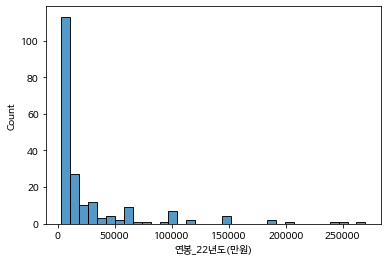

In [28]:
plt.rcParams['font.family'] = 'NanumBarunGothic'
sns.histplot(x = '연봉_22년도(만원)', data = df_n)

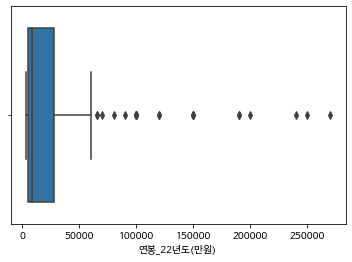

In [29]:
sns.boxplot(x = "연봉_22년도(만원)", data = df_n)

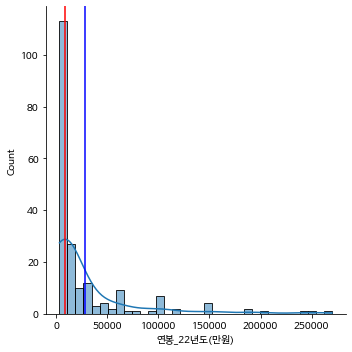

In [30]:
sns.displot(df_n['연봉_22년도(만원)'], kde=True)
plt.axvline(df_n['연봉_22년도(만원)'].mean(), color='blue')
plt.axvline(df_n['연봉_22년도(만원)'].median(), color='red');

In [31]:
def plot_hist_each_column(df):
    plt.rcParams['figure.figsize'] = [25, 20]
    fig = plt.figure(1)
    fig.subplots_adjust(hspace=0.5)
    
    # df의 column 갯수 만큼의 subplot을 출력한다.
    for i in range(len(df.columns)):
        ax = fig.add_subplot(5, 5, i+1)
        plt.hist(df[df.columns[i]], bins=50)
        ax.set_title(df.columns[i])
    plt.show()

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


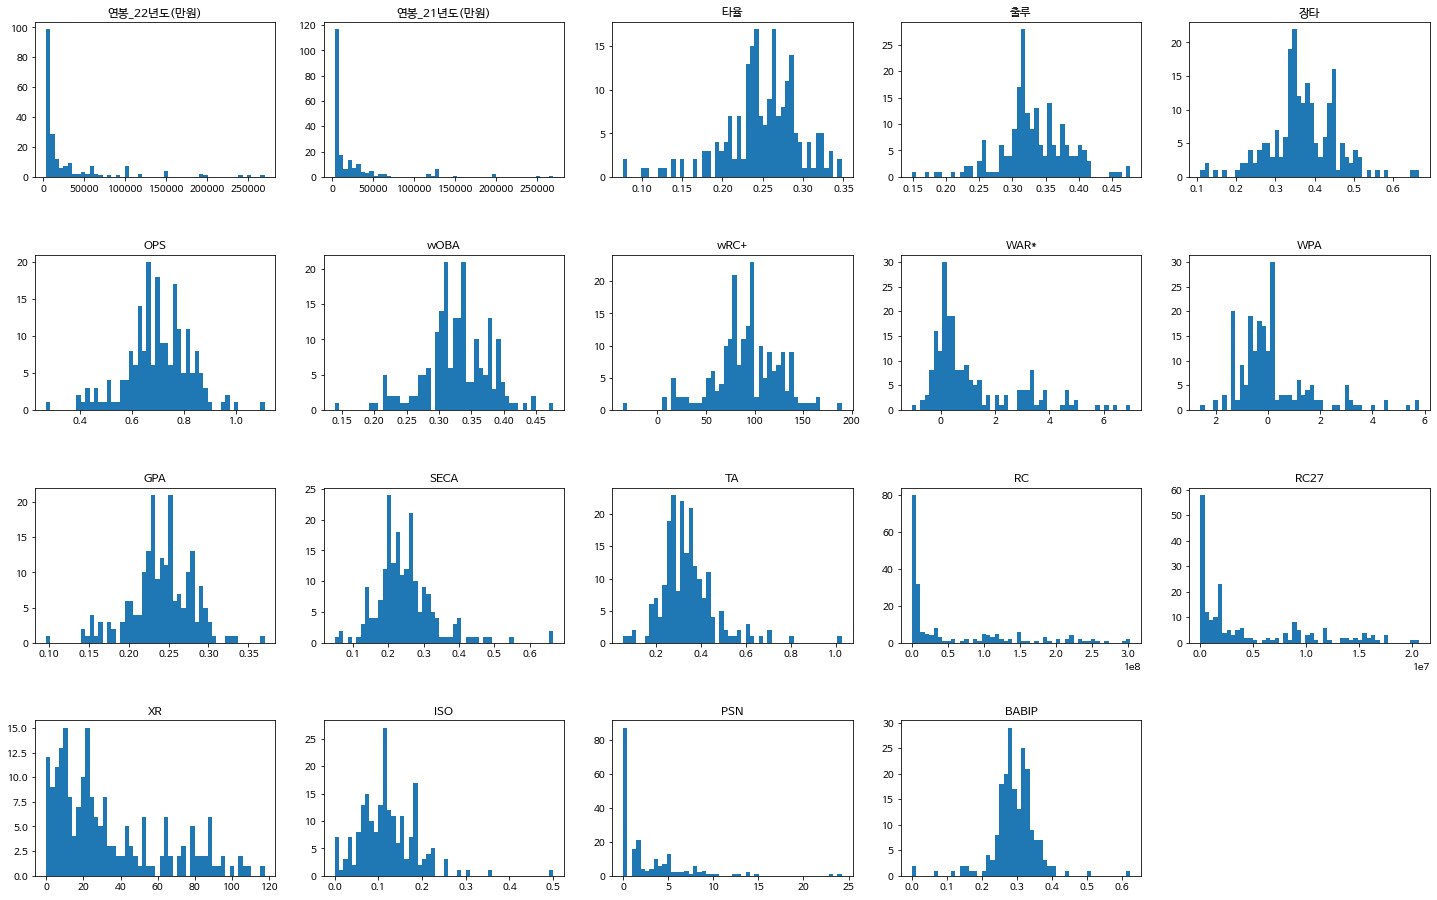

In [32]:
plot_hist_each_column(df_n.drop(['팀', '선수'], axis = 1))

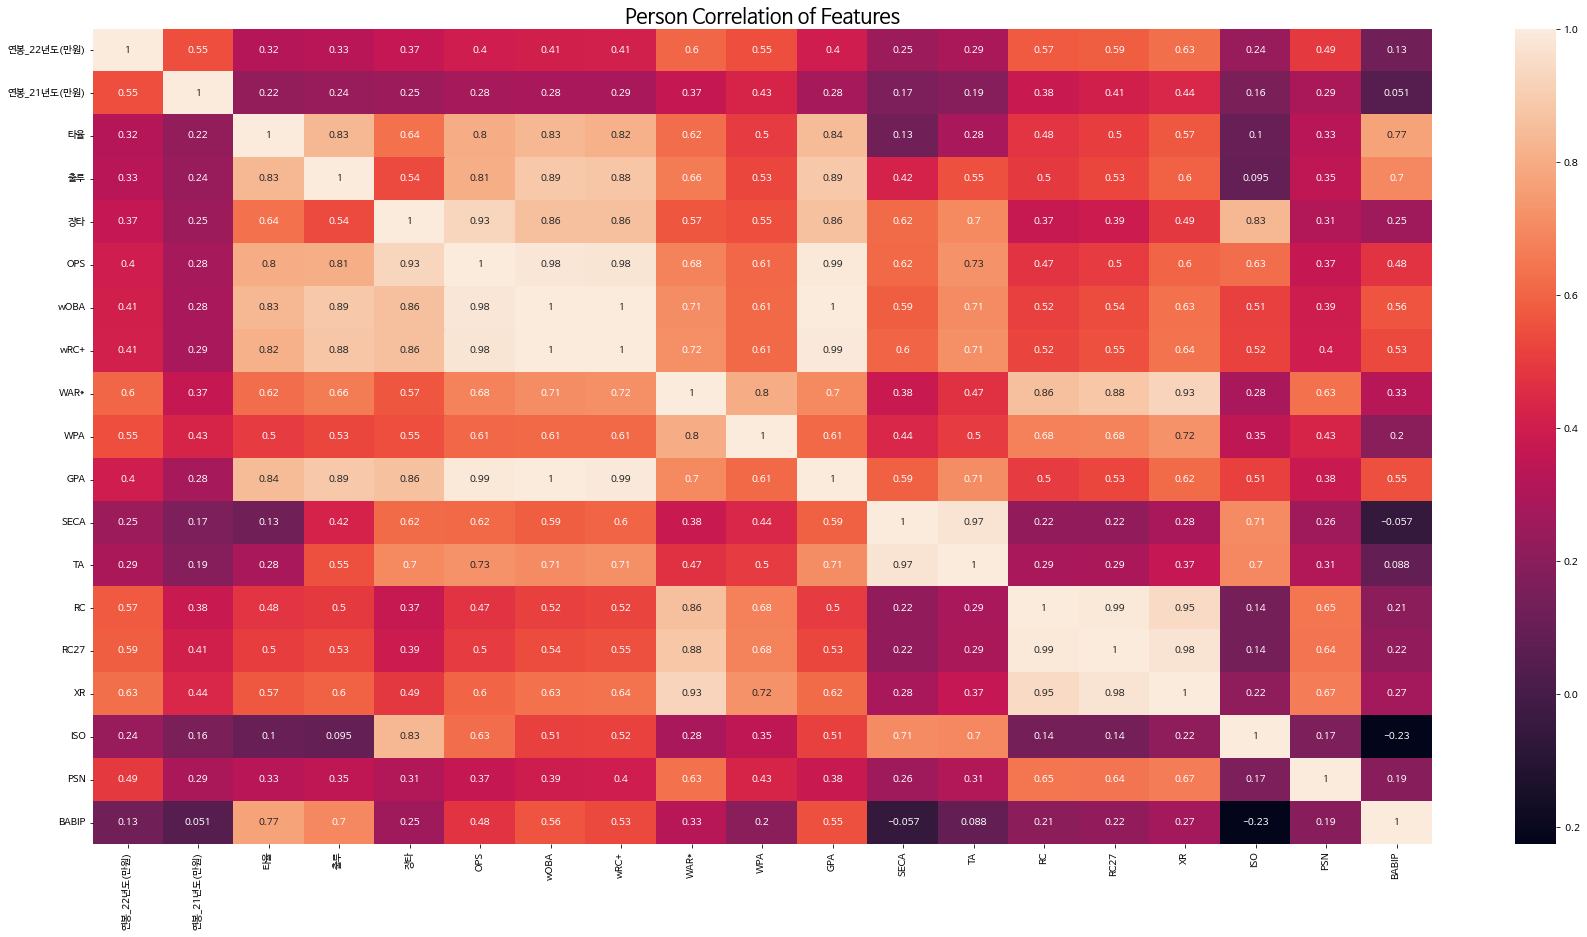

In [33]:
plt.figure(figsize=(30, 15)) 
plt.title("Person Correlation of Features", y = 1, size = 20)
sns.heatmap(df_n.drop(['팀', '선수'], axis = 1).corr(), annot=True)

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


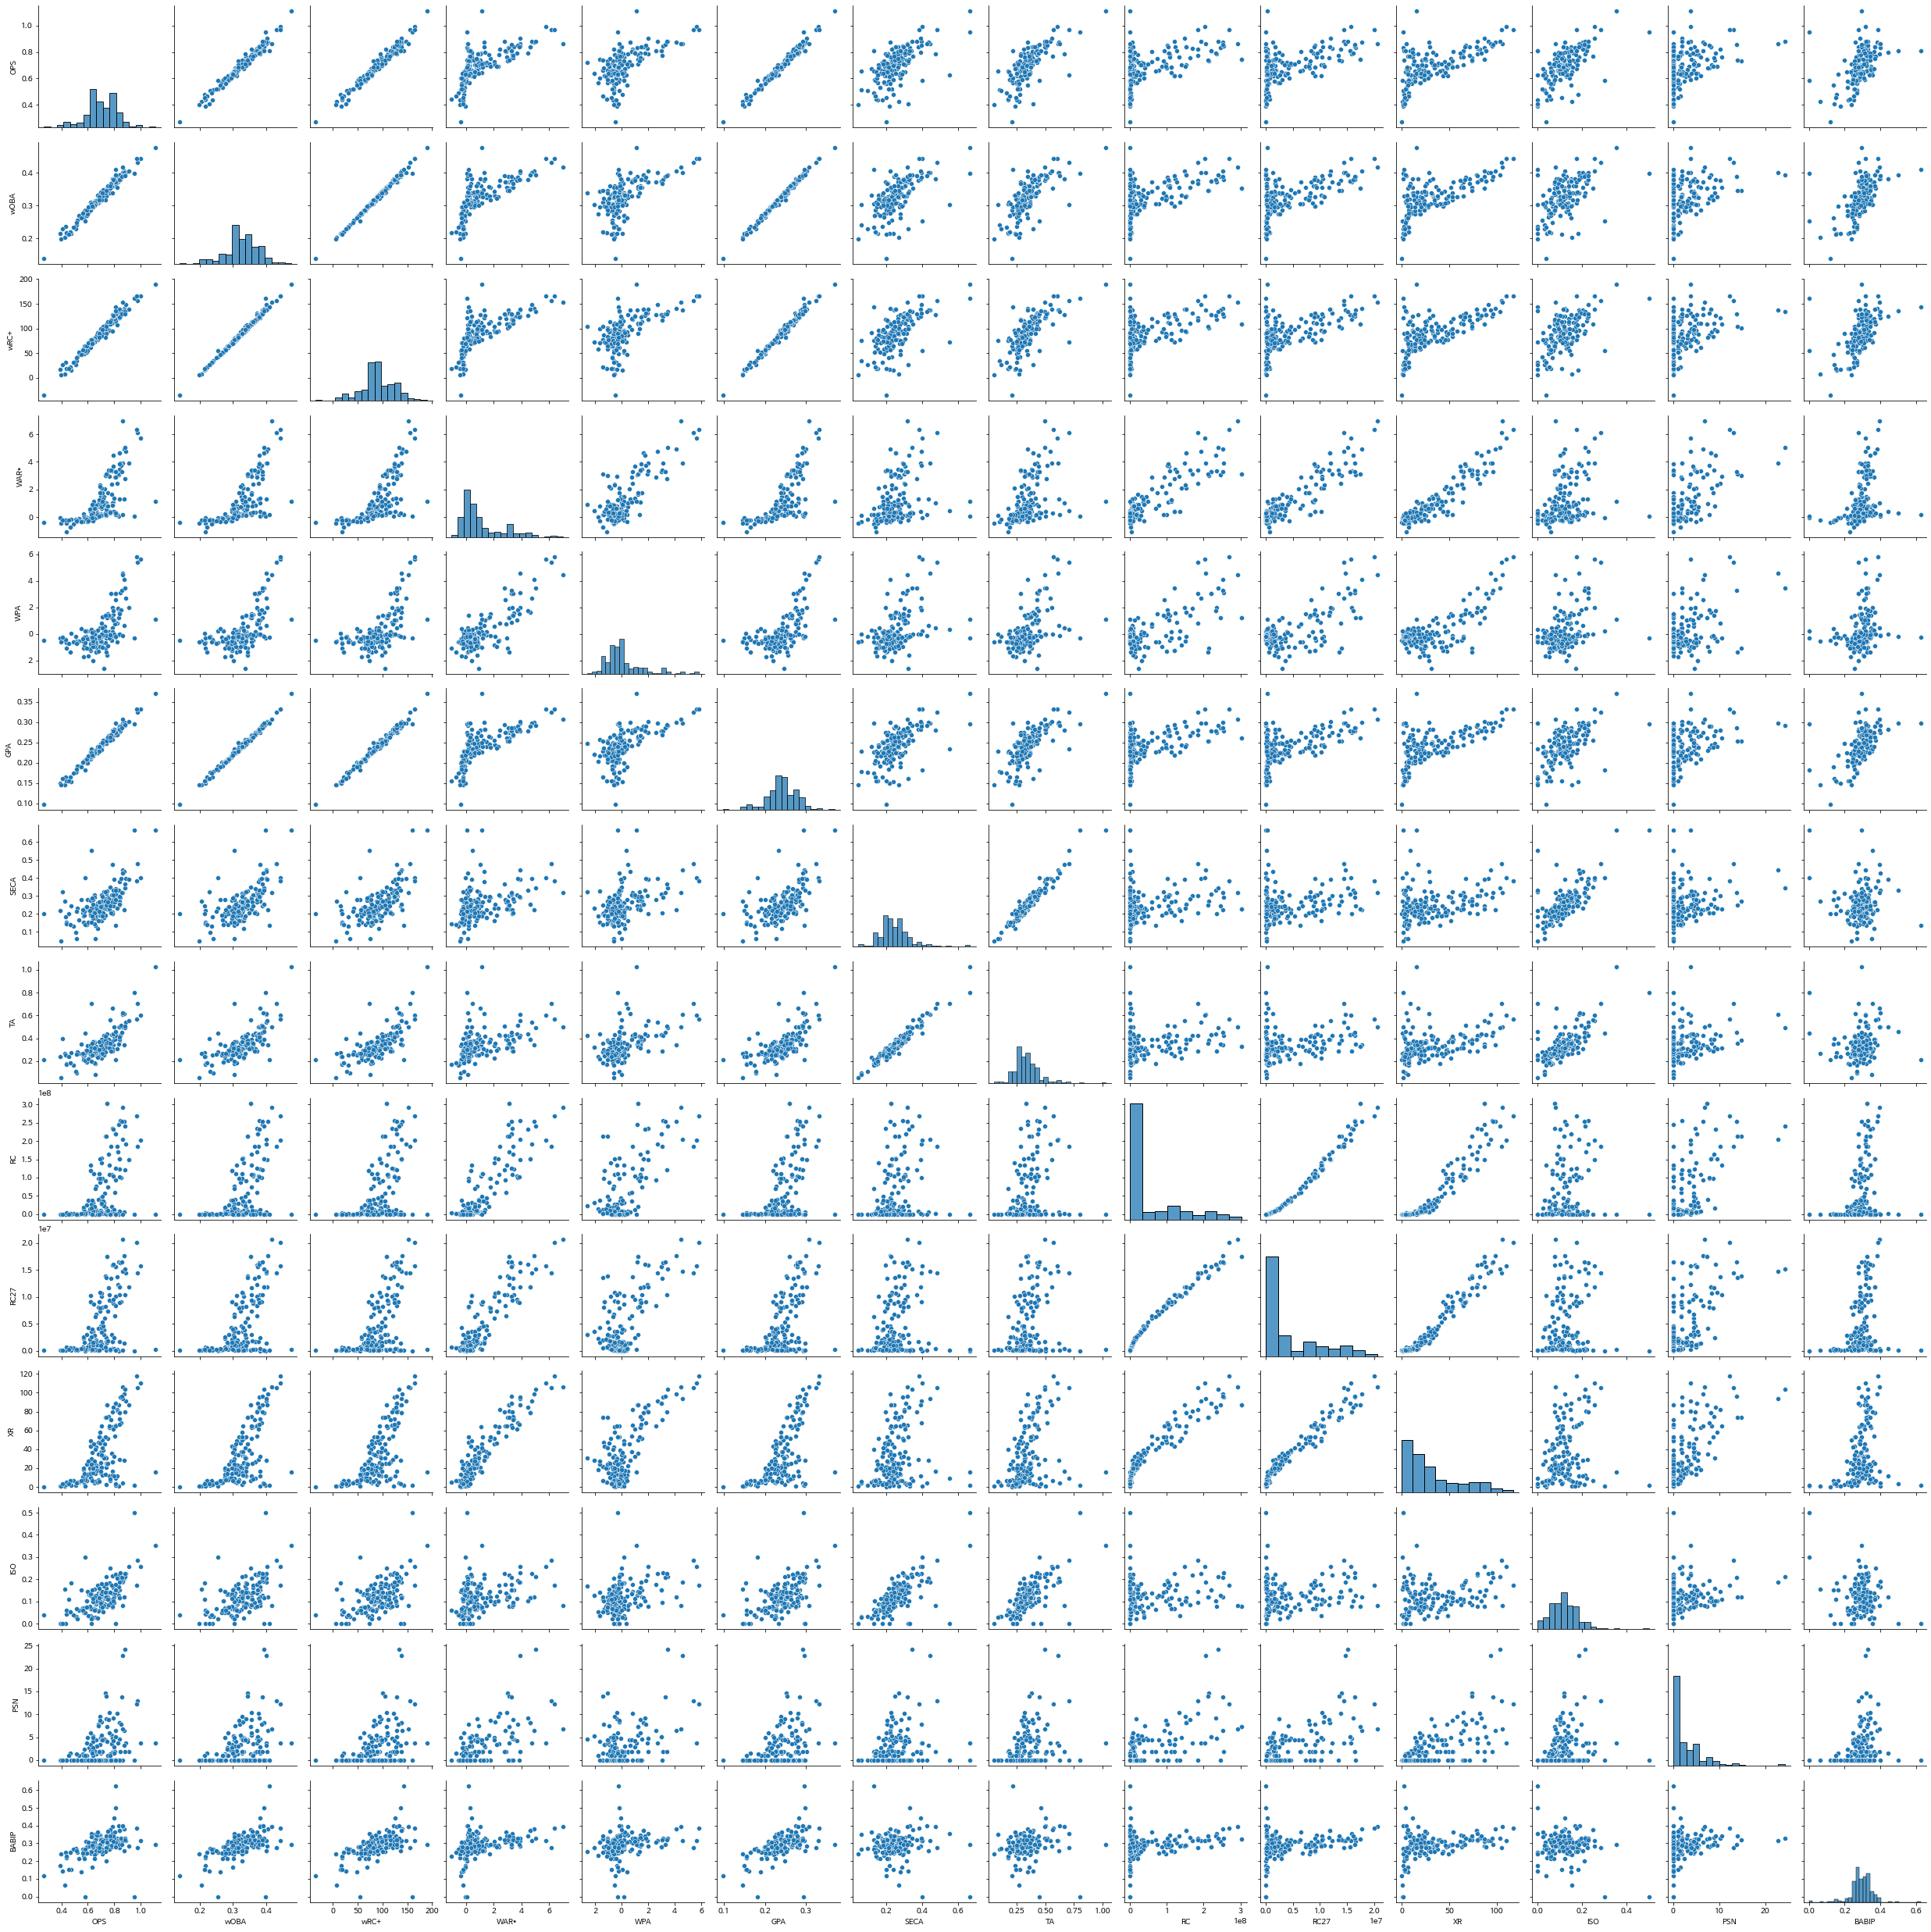

In [61]:
sns.pairplot(df_n.drop(['팀', '선수', '연봉_22년도(만원)', '연봉_21년도(만원)', '타율', '출루', '장타'], axis = 1))
plt.show()

### 선형회귀분석

In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [35]:
# 기준모델
predict = df_n['연봉_22년도(만원)'].mean()
y_base = [predict]*len(df_n)

In [85]:
target = "연봉_22년도(만원)"

X = df_n.drop([target, '팀', '선수', '연봉_21년도(만원)'], axis = 1)
y = df_n[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

In [86]:
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((128, 17), (33, 17), (41, 17), (128,), (33,), (41,))

In [87]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [88]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

y_base = [predict]*len(X_val)

mse = mean_squared_error(y_val, y_base)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val, y_base)
r2 = r2_score(y_val, y_base)

print("mse : ", mse)
print("rmse : ", rmse)
print("mae : ", mae)
print("r2 : ", r2)

mse :  3198260156.891407
rmse :  56553.162218318146
mae :  34043.35283528353
r2 :  -0.002074575426101344


In [89]:
print('coefficient : ', lr.coef_)
print('intercept : ', lr.intercept_)

coefficient :  [-6.89123023e+05 -2.17408142e+06 -1.46120010e+06  2.42823777e+06
 -5.46423624e+05  1.51040374e+03 -1.96274967e+03  3.62647013e+03
 -1.34363359e+06  8.38989877e+04 -5.23091631e+04  3.13709737e-04
 -1.09433102e-02  1.84118180e+03 -7.72077007e+05  1.34893705e+03
 -5.19460599e+04]
intercept :  195140.07885594954


[Text(0, 0, '타율'),
 Text(0, 0, '출루'),
 Text(0, 0, '장타'),
 Text(0, 0, 'OPS'),
 Text(0, 0, 'wOBA'),
 Text(0, 0, 'wRC+'),
 Text(0, 0, 'WAR*'),
 Text(0, 0, 'WPA'),
 Text(0, 0, 'GPA'),
 Text(0, 0, 'SECA'),
 Text(0, 0, 'TA'),
 Text(0, 0, 'RC'),
 Text(0, 0, 'RC27'),
 Text(0, 0, 'XR'),
 Text(0, 0, 'ISO'),
 Text(0, 0, 'PSN'),
 Text(0, 0, 'BABIP')]

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


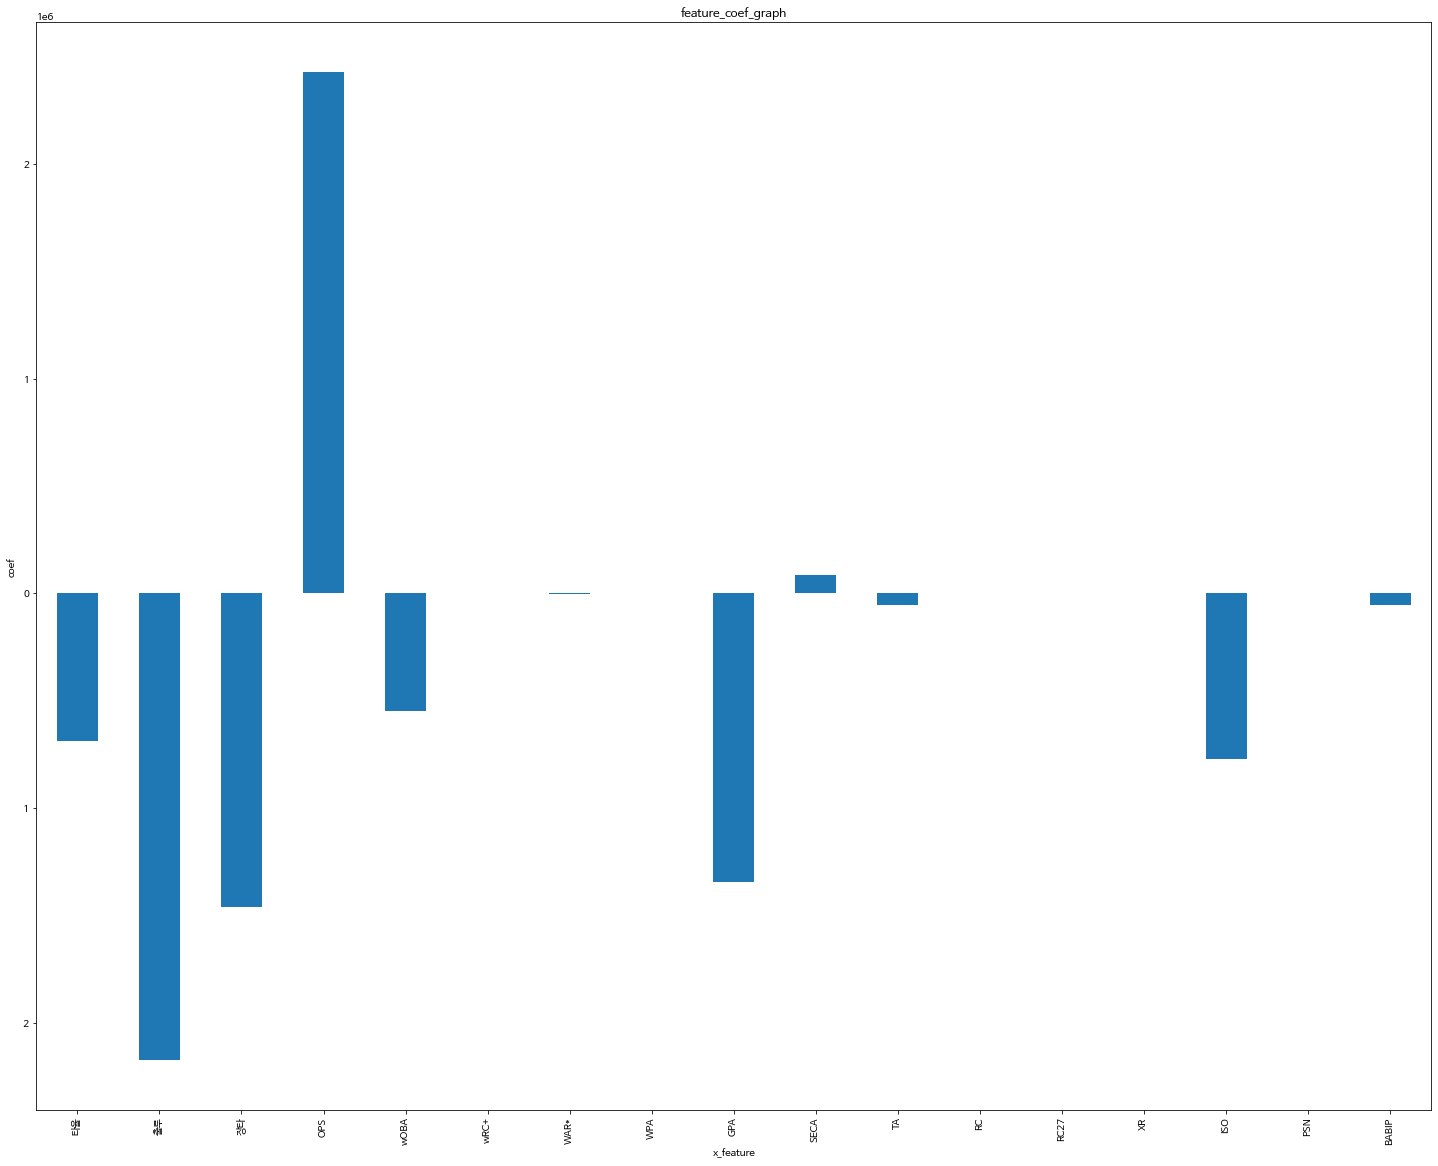

In [90]:
coefs_series = pd.Series(lr.coef_)
ax = coefs_series.plot(kind = 'bar')
ax.set_title('feature_coef_graph')
ax.set_xlabel('x_feature')
ax.set_ylabel('coef')
ax.set_xticklabels(X_train.columns)

In [91]:
y_pred = lr.predict(X_val)

mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print("mse : ", mse)
print("rmse : ", rmse)
print("mae : ", mae)
print("r2 : ", r2)

mse :  1949816392.7007673
rmse :  44156.72533941763
mae :  26073.601148359357
r2 :  0.38908614745913717


In [92]:
y_pred_t = lr.predict(X_test)

mse = mean_squared_error(y_test, y_pred_t)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_t)
r2 = r2_score(y_test, y_pred_t)

print("mse : ", mse)
print("rmse : ", rmse)
print("mae : ", mae)
print("r2 : ", r2)

mse :  2278913330.8260946
rmse :  47737.965298346084
mae :  28756.06449717131
r2 :  0.30962075998400584


검증셋의 성능도 좋진 않았지만, 테스트셋의 성능이 이렇게 안좋다니 ..  
과적합 되어있는건가

### 변수선택

In [93]:
# 단계별 선택법

import statsmodels.api as sm

## 전진 단계별 선택법
variables = X_train.columns.tolist() ## 설명 변수 리스트
 
y = y_train ## 반응 변수
selected_variables = [] ## 선택된 변수들
sl_enter = 0.05
sl_remove = 0.05
 
sv_per_step = [] ## 각 스텝별로 선택된 변수들
adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수
steps = [] ## 스텝
step = 0
while len(variables) > 0:
    remainder = list(set(variables) - set(selected_variables))
    pval = pd.Series(index=remainder) ## 변수의 p-value
    ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서 
    ## 선형 모형을 적합한다.
    for col in remainder: 
        X = X_train[selected_variables+[col]]
        X = sm.add_constant(X)
        model = sm.OLS(y,X).fit()
        pval[col] = model.pvalues[col]
 
    min_pval = pval.min()
    if min_pval < sl_enter: ## 최소 p-value 값이 기준 값보다 작으면 포함
        selected_variables.append(pval.idxmin())
        ## 선택된 변수들에대해서
        ## 어떤 변수를 제거할지 고른다.
        while len(selected_variables) > 0:
            selected_X = X_train[selected_variables]
            selected_X = sm.add_constant(selected_X)
            selected_pval = sm.OLS(y,selected_X).fit().pvalues[1:] ## 절편항의 p-value는 뺀다
            max_pval = selected_pval.max()
            if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외
                remove_variable = selected_pval.idxmax()
                selected_variables.remove(remove_variable)
            else:
                break
        
        step += 1
        steps.append(step)
        adj_r_squared = sm.OLS(y,sm.add_constant(X_train[selected_variables])).fit().rsquared_adj
        adjusted_r_squared.append(adj_r_squared)
        sv_per_step.append(selected_variables.copy())
    else:
        break

<ipython-input-93-a0ab86ad5ffc>:19: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pval = pd.Series(index=remainder) ## 변수의 p-value
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: Fut

In [94]:
selected_variables

['XR', 'PSN']

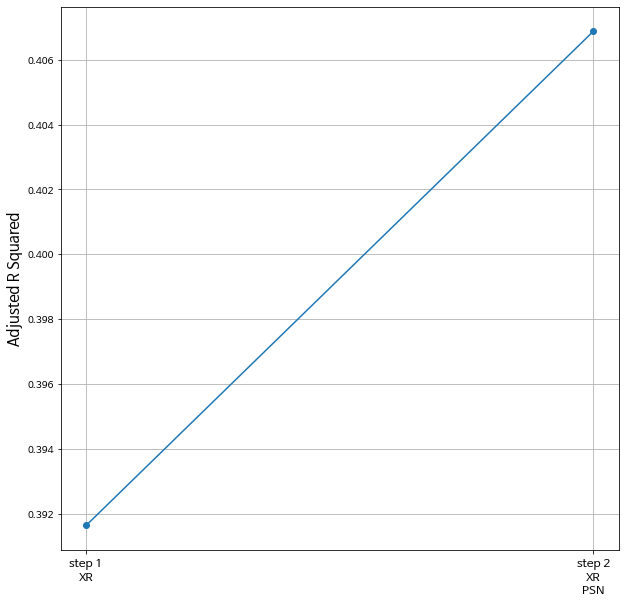

In [95]:
fig = plt.figure(figsize=(10,10))
fig.set_facecolor('white')
 
font_size = 15
plt.xticks(steps,[f'step {s}\n'+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)], fontsize=12)
plt.plot(steps,adjusted_r_squared, marker='o')
    
plt.ylabel('Adjusted R Squared',fontsize=font_size)
plt.grid(True)
plt.show()

### 주성분 분석

In [96]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X_train = StandardScaler().fit_transform(X_train)

pca = PCA(n_components=5)
p_fit = pca.fit_transform(X_train)
rst = pd.DataFrame(data=p_fit)
rst.head()

,0,1,2,3,4
0,-1.276751,1.093924,2.313781,-0.039814,-0.096486
1,1.541140,0.635940,0.825520,-0.225679,0.224178
2,5.649154,-1.392177,-0.066313,0.073944,0.333076
3,-3.096897,4.331508,-0.325982,1.796637,0.137144
4,-3.696755,0.330278,-0.720529,-0.819672,-1.132499


In [97]:
result = pd.DataFrame({'설명가능한 분산 비율(고윳값)':pca.explained_variance_,
                       '기여율':pca.explained_variance_ratio_},
                      index = np.array([f"pca{num+1}" for num in range(5)]))
result['누적기여율'] = result['기여율'].cumsum()
result

,설명가능한 분산 비율(고윳값),기여율,누적기여율
pca1,10.700874,0.624546,0.624546
pca2,2.510252,0.146508,0.771054
pca3,1.850627,0.108010,0.879064
pca4,0.756134,0.044131,0.923195
pca5,0.627343,0.036614,0.959809


누적기여율이 80%가 넘는 pca3 즉, 제 3주성분까지

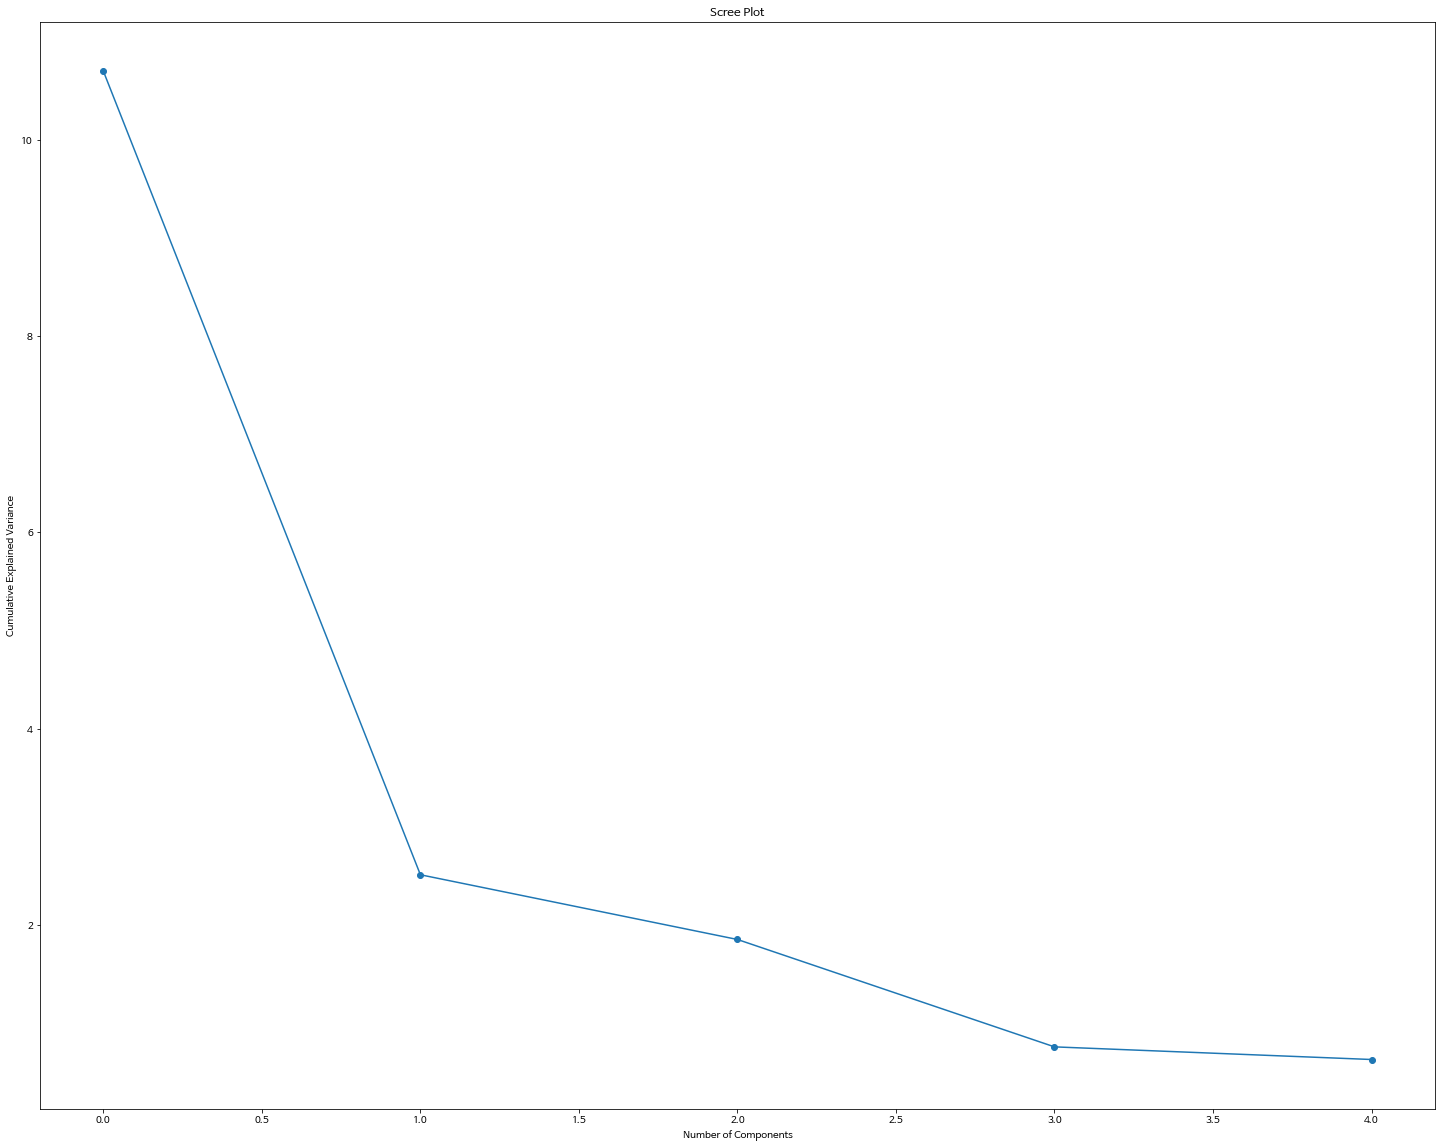

In [98]:
plt.title('Scree Plot')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.plot(pca.explained_variance_, '-o')

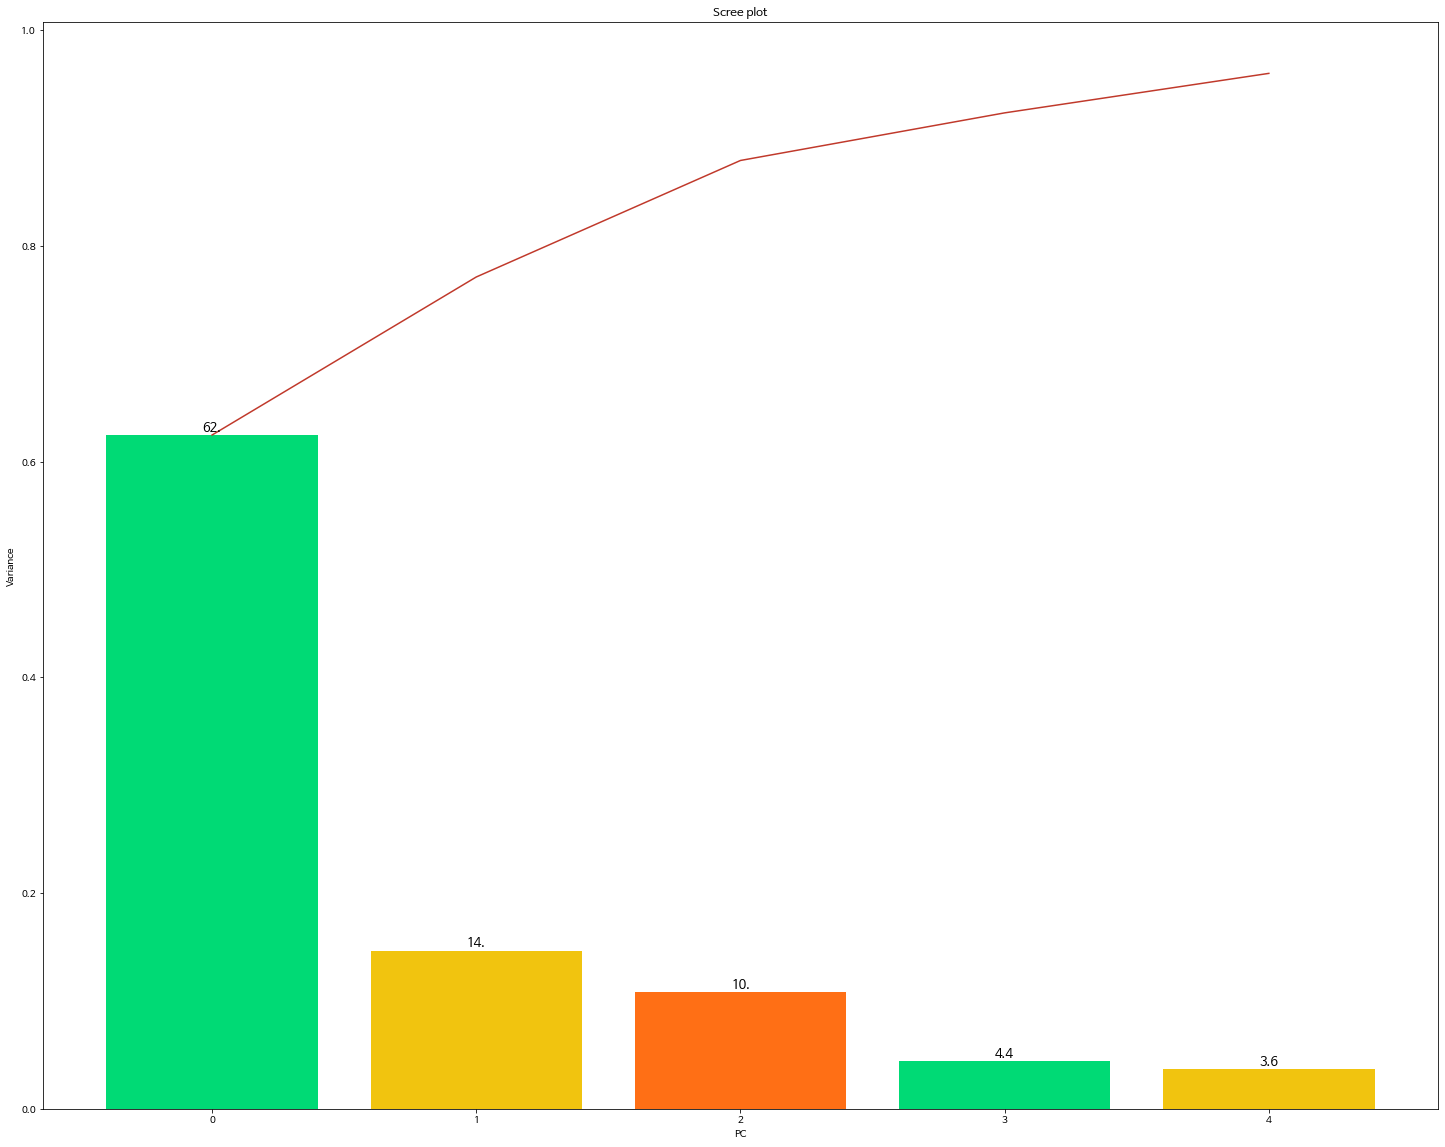

In [99]:
def scree_plot(pca):
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
    
    ax = plt.subplot()
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals, color = ['#00da75', '#f1c40f',  '#ff6f15']) # Bar plot
    ax.plot(ind, cumvals, color = '#c0392b') # Line plot 
    
    for i in range(num_components):
        ax.annotate(r"%s" % ((str(vals[i]*100)[:3])), (ind[i], vals[i]), va = "bottom", ha = "center", fontsize = 13)
     
    ax.set_xlabel("PC")
    ax.set_ylabel("Variance")
    plt.title('Scree plot')
  
scree_plot(pca)

### 다시 회귀모델 학습

In [100]:
target = "연봉_22년도(만원)"

X = df_n[["XR", "PSN"]]
y = df_n[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

In [101]:
lr = LinearRegression()
model = lr.fit(X_train, y_train)

print(model.score(X_train, y_train))

0.4162169303998783


In [102]:
y_pred = lr.predict(X_val)

mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print("mse : ", mse)
print("rmse : ", rmse)
print("mae : ", mae)
print("r2 : ", r2)

mse :  1834722844.5965703
rmse :  42833.66485133592
mae :  26081.979265050057
r2 :  0.4251471033204939


In [103]:
y_pred_t = lr.predict(X_test)

mse = mean_squared_error(y_test, y_pred_t)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_t)
r2 = r2_score(y_test, y_pred_t)

print("mse : ", mse)
print("rmse : ", rmse)
print("mae : ", mae)
print("r2 : ", r2)

mse :  2336908880.5735507
rmse :  48341.585416425376
mae :  26772.922405198835
r2 :  0.2920514549045342


In [123]:
X = df_n[["XR", "PSN"]]
predict_23_salary = lr.predict(X)
predict_23_salary[:5]
df_n['예측연봉(2022)'] = pd.Series(predict_23_salary)

In [124]:
df_n.head()

,팀,선수,연봉_22년도(만원),연봉_21년도(만원),타율,출루,장타,OPS,wOBA,wRC+,...,SECA,TA,RC,RC27,XR,ISO,PSN,BABIP,예측연봉(2023),예측연봉(2022)
0,롯데,안치홍,100000,29000,0.306,0.379,0.458,0.838,0.382,124.3,...,0.268409,0.376623,1.235645e+08,1.045844e+07,71.806,0.152,4.615385,0.324251,54174.630635,54174.630635
1,롯데,이대호,80000,250000,0.286,0.342,0.448,0.790,0.361,111.3,...,0.242857,0.342949,1.040696e+08,8.836095e+06,63.650,0.162,0.000000,0.282913,39887.970955,39887.970955
2,롯데,정훈,55000,6400,0.292,0.380,0.438,0.819,0.377,121.9,...,0.300412,0.424501,1.848595e+08,1.378787e+07,82.438,0.146,10.181818,0.330749,71931.477140,71931.477140
3,롯데,전준우,50000,50000,0.348,0.405,0.469,0.874,0.406,140.4,...,0.222826,0.343164,2.528092e+08,1.772948e+07,98.872,0.121,6.461538,0.383023,75639.326928,75639.326928
4,롯데,한동희,17200,4700,0.267,0.364,0.443,0.807,0.373,119.0,...,0.318396,0.423423,1.259191e+08,1.008848e+07,65.130,0.176,0.000000,0.302839,40867.236612,40867.236612


In [129]:
result_df = df_n.sort_values(by=['연봉_22년도(만원)'], ascending = False)

result_df = result_df[['선수', '예측연봉(2022)','연봉_22년도(만원)','연봉_21년도(만원)']]
result_df.columns = ['선수','예측연봉(2022)','실제연봉(2022)','작년연봉(2021)']

In [128]:
result_df

,선수,예측연봉(2022),실제연봉(2022),작년연봉(2022)
64,추신수,103530.671968,270000,270000
188,구자욱,113144.899066,250000,28000
65,한유섬,59382.172927,240000,25000
153,나성범,64668.025733,200000,50000
94,박건우,65762.981771,190000,3000
...,...,...,...,...
106,박준영,26793.593267,3000,2700
115,이주형,-1622.306229,3000,3000
18,김민수,12226.362820,3000,6500
17,김민수,5207.410060,3000,6500


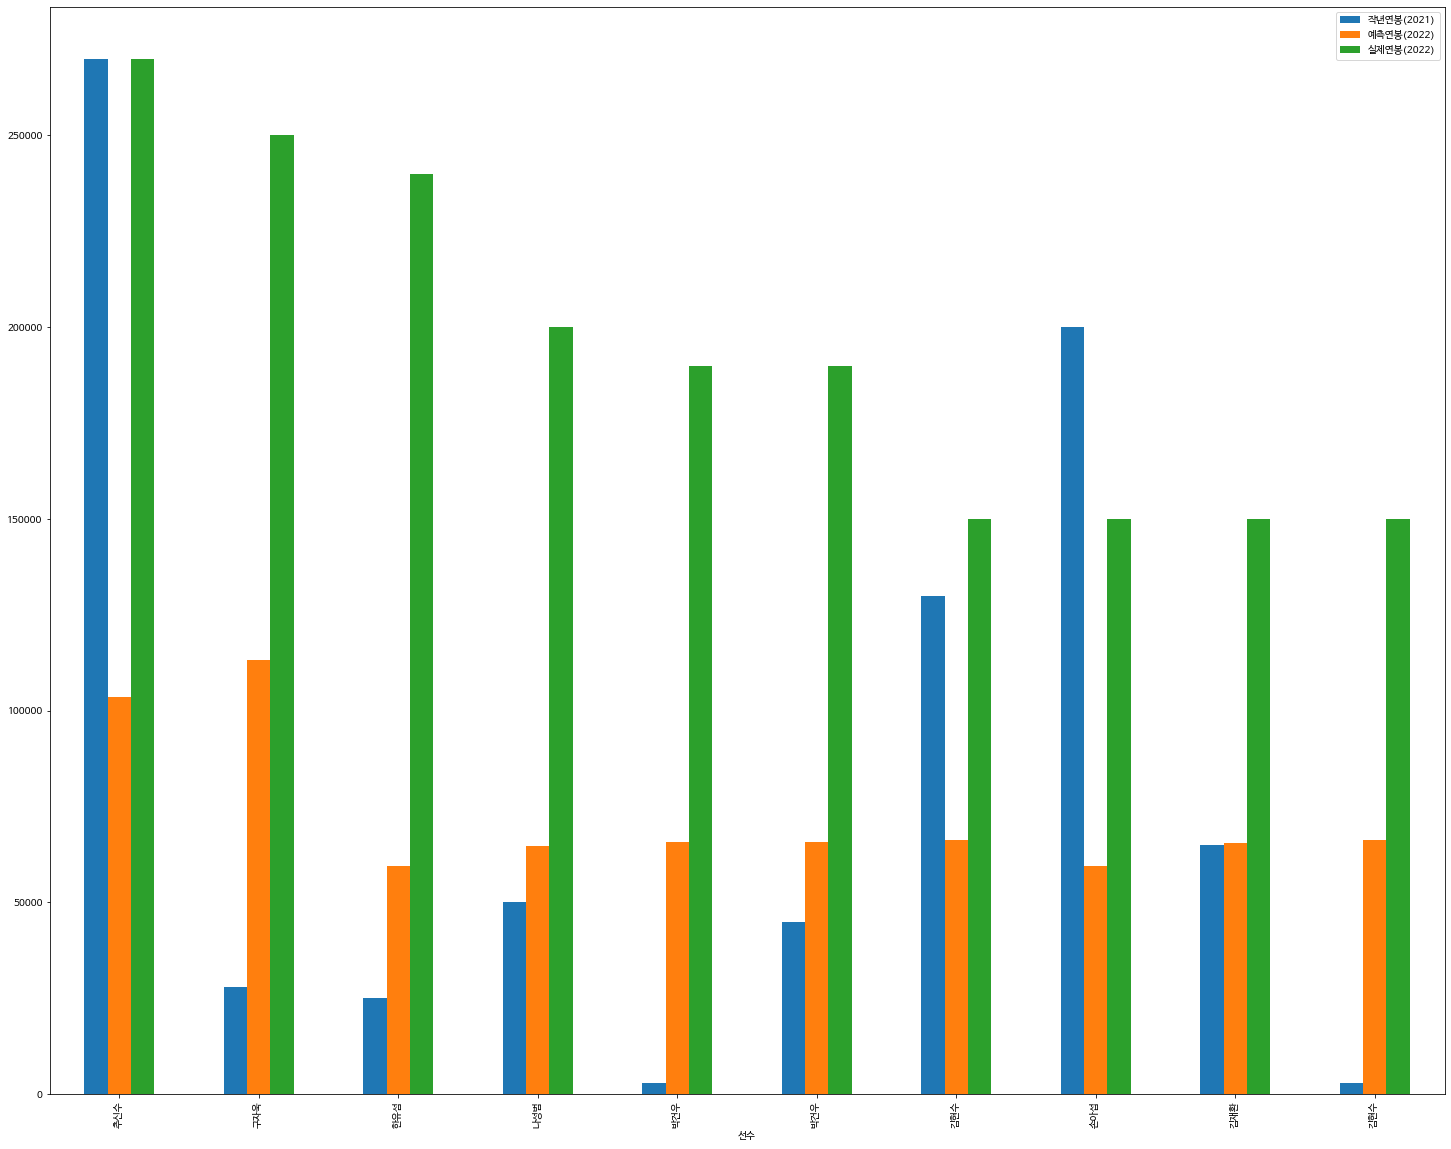

In [130]:
result_df = result_df.iloc[:10,:]
result_df.plot(x='선수', y=['작년연봉(2021)','예측연봉(2022)','실제연봉(2022)'], kind='bar')